# Centre backs who contribute to the build-up phase

In [1]:
###  Source of the data: https://fbref.com/
#    Football competitions analyzed (6): American Major League Soccer, English Premier League, French Ligue 1, German Bundesliga, Italian Serie A, Spanish La Liga
#    Main objective of the project: Find centre backs who contribute to the build-up phase.
#  Notes:
# - fbref doesn't show CBs separately in their tables, only defenders as 'DF'
# - the following player filters have been applied:
#    - the player is a DF (defender)
#    - the player played at least 40% of their team's matches (at least 40% of squad 90s)
#    - (vizualization) top 50 defenders only who has the highest touch / 90 min in the defensive 3rd

## DF for All Players: df_final
## DF for Top 50 Players in number of toucher per 90 minutes in the defensive third: df_final_50

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
import os
import matplotlib.font_manager as fm
from pylab import rcParams
import requests


## Import dataframes we'll need

In [3]:
## 1 - build links list for df_passing
## 1 - df_passing - (Passing table of players)

links_passing = [
    'https://fbref.com/en/comps/9/passing/Premier-League-Stats',
    'https://fbref.com/en/comps/12/passing/La-Liga-Stats',
    'https://fbref.com/en/comps/13/passing/Ligue-1-Stats',
    'https://fbref.com/en/comps/20/passing/Bundesliga-Stats',
    'https://fbref.com/en/comps/11/passing/Serie-A-Stats',
    'https://fbref.com/en/comps/22/passing/Major-League-Soccer-Stats'
]

In [4]:
df_passing = pd.DataFrame()
for link in links_passing:
    html_content = requests.get(link).text.replace('<!--', '').replace('-->', '')
    data = pd.read_html(html_content)[2]
    print(data.shape)
    df_passing = df_passing.append(data,ignore_index=True)

df_passing.shape # checking the output

(530, 31)
(606, 31)
(591, 31)
(505, 31)
(609, 31)
(772, 31)


(3613, 31)

In [5]:
## 2 - build links for possession using the passing links URL - replacing keywords
## 2 - df_possession - (Possession table of players)

links_possession = []

for link in links_passing:
    new_link = link.replace("passing", "possession")
    links_possession.append(new_link)

In [6]:
df_possession = pd.DataFrame()
for link in links_possession:
    html_content = requests.get(link).text.replace('<!--', '').replace('-->', '')
    data = pd.read_html(html_content)[2]
    print(data.shape)
    df_possession = df_possession.append(data,ignore_index=True)
    
df_possession.shape # checking the output

(530, 33)
(606, 33)
(591, 33)
(505, 33)
(609, 33)
(772, 33)


(3613, 33)

In [7]:
## 3 - links_passing to be used as the table is on the same page (same URL)
## 3 - df_teams - (Teams table of players)

df_teams = pd.DataFrame()
for link in links_passing:
    html_content = requests.get(link).text.replace('<!--', '').replace('-->', '')
    data = pd.read_html(html_content)[0]
    print(data.shape)
    df_teams = df_teams.append(data,ignore_index=True)

df_teams.shape # checking the output

(20, 25)
(20, 25)
(20, 25)
(18, 25)
(20, 25)
(27, 25)


(125, 25)

## Clean the Dataframes

In [8]:
## drop multiIndices - drop level 0

df_passing.columns = df_passing.columns.droplevel(level = 0)
df_possession.columns = df_possession.columns.droplevel(level = 0)
df_teams.columns = df_teams.columns.droplevel(level = 0)

In [9]:
## check for Player names value counts

df_passing['Player'].value_counts()

Player               136
Jürgen Locadia         3
Dominique Heintz       2
Edoardo Goldaniga      2
Dominique Badji        2
                    ... 
Mohamed Elneny         1
Roger Ibanez           1
Enzo Millot            1
Ben Davies             1
Ebrima Colley          1
Name: Player, Length: 3327, dtype: int64

In [10]:
## as both df_passing and df_possession are similar, we must drop rows where Player col == 'Player'

df_passing = df_passing[df_passing['Player'] != 'Player']
df_possession = df_possession[df_possession['Player'] != 'Player']

In [11]:
## rename the first (10th value) (as MultiIndex level = 0 is dropped) CMP% (Total) as 'Total_Passing%' in the df_passing
print(df_passing.columns.values)
df_passing.columns.values[10] = 'Total_Passing%'
print('after change', df_passing.columns.values)

['Rk' 'Player' 'Nation' 'Pos' 'Squad' 'Age' 'Born' '90s' 'Cmp' 'Att'
 'Cmp%' 'TotDist' 'PrgDist' 'Cmp' 'Att' 'Cmp%' 'Cmp' 'Att' 'Cmp%' 'Cmp'
 'Att' 'Cmp%' 'Ast' 'xA' 'A-xA' 'KP' '1/3' 'PPA' 'CrsPA' 'Prog' 'Matches']
after change ['Rk' 'Player' 'Nation' 'Pos' 'Squad' 'Age' 'Born' '90s' 'Cmp' 'Att'
 'Total_Passing%' 'TotDist' 'PrgDist' 'Cmp' 'Att' 'Cmp%' 'Cmp' 'Att'
 'Cmp%' 'Cmp' 'Att' 'Cmp%' 'Ast' 'xA' 'A-xA' 'KP' '1/3' 'PPA' 'CrsPA'
 'Prog' 'Matches']


In [12]:
## make sure that Total_Passing% is available for calculations
df_passing['Total_Passing%'] = df_passing['Total_Passing%'].astype(float)
print('type of first value:' , type(df_passing['Total_Passing%'][0]))

type of first value: <class 'numpy.float64'>


In [13]:
## make sure that df_possession's Def 3rd column can be calculated with (looks like an int-alike string)
df_possession['Def 3rd'] = df_possession['Def 3rd'].astype(int)
print('type of first value:', type(df_possession['Def 3rd'][0]))

type of first value: <class 'numpy.int32'>


## Merge (join) df_passing with df_possession

In [14]:
## joining on more columns to make sure they are joined well
df = pd.merge(df_passing, df_possession, how = 'inner', on= ['Player', 'Nation', 'Pos','Squad', 'Born'])
df.shape

(3477, 59)

In [15]:
df.columns

Index(['Rk_x', 'Player', 'Nation', 'Pos', 'Squad', 'Age_x', 'Born', '90s_x',
       'Cmp', 'Att_x', 'Total_Passing%', 'TotDist_x', 'PrgDist_x', 'Cmp',
       'Att_x', 'Cmp%', 'Cmp', 'Att_x', 'Cmp%', 'Cmp', 'Att_x', 'Cmp%', 'Ast',
       'xA', 'A-xA', 'KP', '1/3_x', 'PPA', 'CrsPA', 'Prog_x', 'Matches_x',
       'Rk_y', 'Age_y', '90s_y', 'Touches', 'Def Pen', 'Def 3rd', 'Mid 3rd',
       'Att 3rd', 'Att Pen', 'Live', 'Succ', 'Att_y', 'Succ%', '#Pl', 'Megs',
       'Carries', 'TotDist_y', 'PrgDist_y', 'Prog_y', '1/3_y', 'CPA', 'Mis',
       'Dis', 'Targ', 'Rec', 'Rec%', 'Prog_y', 'Matches_y'],
      dtype='object')

## Cleaning merged DF and calculations

In [16]:
## calculate Def 3rd touches per 90 minutes (90s_x column) --> df['Def 3rd/90']

In [17]:
## for this, make 90s_x values available for calculations (float)
df['90s_x'] = df['90s_x'].astype(float)

In [18]:
df['Def 3rd/90'] = df['Def 3rd'] / df['90s_x']

In [19]:
## NOW WE HAVE

# Def 3rd/90
# Total_Passing%

In [20]:
## Throw 0, na and inf values in these columns

In [21]:
df = df[df['Def 3rd/90'] != 0]
df = df[df['Total_Passing%'] != 0]

In [22]:
df = df[df['Def 3rd/90'].notna()]
df = df[df['Total_Passing%'].notna()]

In [23]:
df = df[np.isfinite(df['Def 3rd/90'])]

In [24]:
df.shape

(3341, 60)

In [25]:
## select only DFs (might be LW / DF many times)
df = df[df['Pos'].str.contains('DF')]

In [26]:
## create df_final with the necessary columns only
df_final = df[['Player', 'Nation', '90s_x', 'Pos', 'Squad', 'Age_x', 'Total_Passing%', 'Def 3rd/90']]

In [27]:
## merge df_final with df_teams to see the total 90s played per player - first, select the needed columns from df_teams
df_teams= df_teams[['Squad', '90s']]

In [28]:
## convert these to float
df_teams['90s'] = df_teams['90s'].astype(float)

In [29]:
df_final = df_final.merge(df_teams, on = 'Squad')
df_final.shape

(1329, 9)

In [30]:
df_final.head()

,Player,Nation,90s_x,Pos,Squad,Age_x,Total_Passing%,Def 3rd/90,90s
0,Max Aarons,eng ENG,21.9,DF,Norwich City,22-037,74.8,21.598174,23.0
1,Sam Byram,eng ENG,1.7,"DF,MF",Norwich City,28-147,67.9,21.764706,23.0
2,Dimitris Giannoulis,gr GRE,6.1,DF,Norwich City,26-116,75.6,27.213115,23.0
3,Ben Gibson,eng ENG,18.7,DF,Norwich City,29-026,82.5,38.181818,23.0
4,Grant Hanley,sct SCO,18.2,DF,Norwich City,30-082,85.9,34.835165,23.0


In [31]:
df_final.head()

,Player,Nation,90s_x,Pos,Squad,Age_x,Total_Passing%,Def 3rd/90,90s
0,Max Aarons,eng ENG,21.9,DF,Norwich City,22-037,74.8,21.598174,23.0
1,Sam Byram,eng ENG,1.7,"DF,MF",Norwich City,28-147,67.9,21.764706,23.0
2,Dimitris Giannoulis,gr GRE,6.1,DF,Norwich City,26-116,75.6,27.213115,23.0
3,Ben Gibson,eng ENG,18.7,DF,Norwich City,29-026,82.5,38.181818,23.0
4,Grant Hanley,sct SCO,18.2,DF,Norwich City,30-082,85.9,34.835165,23.0


In [32]:
## Only select players who played at least 40% of their team totals
## 90s_x / Team Total Matches Played  >= 40%

df_final.columns

Index(['Player', 'Nation', '90s_x', 'Pos', 'Squad', 'Age_x', 'Total_Passing%',
       'Def 3rd/90', '90s'],
      dtype='object')

In [33]:
df_final = df_final[df_final['90s_x'] / df_final['90s']> 0.4]

In [34]:
df_final.shape

(701, 9)

In [35]:
## sort values by Def 3rd/90 touches (Number of touches per 90 minutes) - select the top 50 only for easier vizualization
df_final_50 = df_final.sort_values(by = ['Def 3rd/90'], ascending = False)[0:50]

In [36]:
df_final_50.head()

,Player,Nation,90s_x,Pos,Squad,Age_x,Total_Passing%,Def 3rd/90,90s
1258,Bressan,br BRA,19.4,DF,FC Dallas,28,89.1,48.298969,34.0
125,Lewis Dunk,eng ENG,14.0,DF,Brighton,30-081,91.2,48.071429,22.0
68,Joachim Andersen,dk DEN,17.4,DF,Crystal Palace,25-255,85.7,47.873563,23.0
1299,Andreu Fontàs,es ESP,33.0,DF,Sporting KC,31,90.5,47.666667,34.0
975,Igor,br BRA,10.5,DF,Fiorentina,24-003,91.9,47.428571,23.0


## Plot the df_final_50 (top 50 defenders in number of touches per 90 minutes in relation to the total passing % of that player)

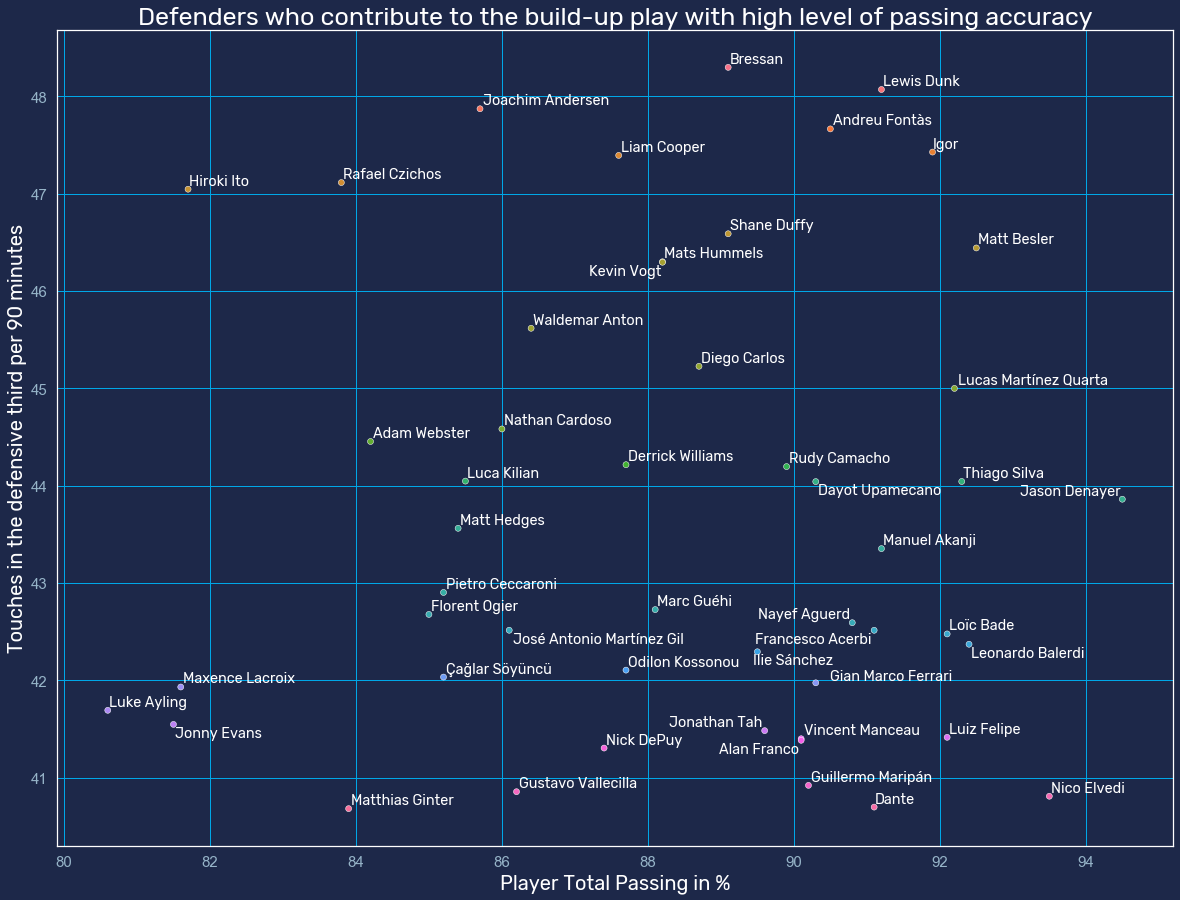

In [37]:
x = df_final_50['Total_Passing%']
y = df_final_50['Def 3rd/90']
labels = df_final_50['Player']

sns.set(rc={'axes.facecolor':'#1d2849', 'figure.facecolor':'#1d2849', 'xtick.color':'#96b4c8', 'ytick.color':'#96b4c8', 'grid.color' : '#00a7e7', 'figure.figsize':(20,15)})

fpath = os.path.join(rcParams['datapath'], r"C:\Users\barnabas.nemeth\Downloads\static\Rubik-Regular.ttf")
prop = fm.FontProperties(fname =fpath)
texts = [plt.text(x_pos, y_pos, f'{l}', fontproperties = prop, color ='white', fontsize = 'large') for (x_pos, y_pos, l) in zip(x,y,labels)]
ax1 = sns.scatterplot(x = x ,y = y, hue = labels, legend = False)

ax1.set_xlabel('Player Total Passing in %' , color='white', fontsize = 20,fontproperties = prop)
ax1.set_ylabel('Touches in the defensive third per 90 minutes', color ='white', fontsize = 20, fontproperties = prop)
ax1.tick_params(axis='both', labelsize=15)
ax1.set_title('Defenders who contribute to the build-up play with high level of passing accuracy', color = 'white', fontsize = 25,fontproperties = prop)

adjust_text(texts) ## note: the adjust_text function may cause slow-down issues depending on the size of the dataframe (currently top 50)

plt.savefig('Defenders_contribution_build-up.png')
plt.show()